# Featurization

This notebook is intended to featurize the data associated with human CRISPRi activity scores to make it easier to train a linear regression model to.

The data used is that from the following paper:

[Compact and highly active next-generation libraries for CRISPR-mediated gene repression and activation](https://elifesciences.org/articles/19760)

__Authors__: Anthony Hein, Briana Macedo, Manya Kapoor

---

###  _TODO: Create similar contribution graph_
### _TODO:  Z-standardize all numerical data__


__Bold == Featurized!__

Features available from data:
- __Distance to TSS (primary and secondary, downstream and upstream)__
- __sgRNA length__
- __(+) or (-) stranded sgRNA__
- __Longest consecutive run of each base__
- __Overall nucleotide composition (% of A, C, T, G, GC, CA, AG)__
- __Nucleotides at each position__
- __Nucleotides dimers at each position__

Features unavailable (stretch goal):
- DNAse-seq signal
- MNase-seq signal
- FAIRE-seq signal
- sgRNA overall folding free energy
- RNA pairing at each position





---

# Notebook Setup

In [2]:
# dataframes
import pandas as pd

# arrays
import numpy as np

# plotting
import matplotlib.pyplot as plt

# regression & support vector machine
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [3]:
# random seed
np.random.seed(0)

# plotting
%matplotlib inline

---

# Data Imports and Checks

In [4]:
# read csvs into dfs & inspect
activity_score_df = pd.read_csv('CRISPRi_Activity_Score_Data.csv')
tss_annotation_df = pd.read_csv('TSS_Annotations.csv')

### Activity Score Dataframe Checks

In [5]:
activity_score_df.head()

,gene symbol,chromosome,PAM genomic coordinate [hg19],strand targeted,sgRNA length (including PAM),sgRNA sequence,"CRISPRi activity score [Horlbeck et al., eLife 2016]"
0,AARS,chr16,70323441,+,24,GCGCTCTGATTGGACGGAGCG,0.019320
1,AARS,chr16,70323216,+,24,GCCCCAGGATCAGGCCCCGCG,0.348892
2,AARS,chr16,70323296,+,24,GGCCGCCCTCGGAGAGCTCTG,0.912409
3,AARS,chr16,70323318,+,24,GACGGCGACCCTAGGAGAGGT,0.997242
4,AARS,chr16,70323362,+,24,GGTGCAGCGGGCCCTTGGCGG,0.962154


In [6]:
activity_score_df.info

<bound method DataFrame.info of       gene symbol chromosome  PAM genomic coordinate [hg19] strand targeted  \
0            AARS      chr16                       70323441               +   
1            AARS      chr16                       70323216               +   
2            AARS      chr16                       70323296               +   
3            AARS      chr16                       70323318               +   
4            AARS      chr16                       70323362               +   
...           ...        ...                            ...             ...   
18375       ZWINT      chr10                       58121021               +   
18376       ZWINT      chr10                       58121033               +   
18377       ZWINT      chr10                       58120760               -   
18378       ZWINT      chr10                       58120818               -   
18379       ZWINT      chr10                       58120898               -   

       sgRNA length

In [7]:
activity_score_df.dtypes

gene symbol                                              object
chromosome                                               object
PAM genomic coordinate [hg19]                             int64
strand targeted                                          object
sgRNA length (including PAM)                              int64
sgRNA sequence                                           object
CRISPRi activity score [Horlbeck et al., eLife 2016]    float64
dtype: object

### TSS Annotation Dataframe Checks

In [8]:
tss_annotation_df.head()

,gene,transcript,chromosome,strand,TSS source,"Primary TSS, 5'","Primary TSS, 3'","Secondary TSS, 5'","Secondary TSS, 3'"
0,A1BG,P1,chr19,-,"CAGE, matched peaks",58858938,58859039,58858938,58859039
1,A1BG,P2,chr19,-,"CAGE, matched peaks",58864822,58864847,58864822,58864847
2,A1CF,P1P2,chr10,-,"CAGE, matched peaks",52645379,52645393,52645379,52645393
3,A2M,P1P2,chr12,-,"CAGE, matched peaks",9268507,9268523,9268528,9268542
4,A2ML1,P1P2,chr12,+,"CAGE, matched peaks",8975206,8975223,8975144,8975169


In [9]:
tss_annotation_df.info

<bound method DataFrame.info of                  gene transcript chromosome strand           TSS source  \
0                A1BG         P1      chr19      -  CAGE, matched peaks   
1                A1BG         P2      chr19      -  CAGE, matched peaks   
2                A1CF       P1P2      chr10      -  CAGE, matched peaks   
3                 A2M       P1P2      chr12      -  CAGE, matched peaks   
4               A2ML1       P1P2      chr12      +  CAGE, matched peaks   
...               ...        ...        ...    ...                  ...   
20878          UQCRHL       P1P2       chr1      -  CAGE, matched peaks   
20879          WTH3DI       P1P2       chr2      -  CAGE, matched peaks   
20880             ZAK       P1P2       chr2      +  CAGE, matched peaks   
20881    ZHX1-C8ORF76       P1P2       chr8      -  CAGE, matched peaks   
20882  ZNF664-FAM101A       P1P2      chr12      +  CAGE, primary peaks   

       Primary TSS, 5'  Primary TSS, 3'  Secondary TSS, 5'  Seconda

In [10]:
tss_annotation_df.dtypes

gene                 object
transcript           object
chromosome           object
strand               object
TSS source           object
Primary TSS, 5'       int64
Primary TSS, 3'       int64
Secondary TSS, 5'     int64
Secondary TSS, 3'     int64
dtype: object

### Column Renaming (for convenience)

In [11]:
new_colnames = {
    "gene symbol" : "gene",
    "PAM genomic coordinate [hg19]" : "coordinate",
    "strand targeted" : "strand",
    "sgRNA length (including PAM)" : "length",
    "sgRNA sequence" : "sequence",
    "CRISPRi activity score [Horlbeck et al., eLife 2016]" : "score"
}
activity_score_df = activity_score_df.rename(columns=new_colnames)

In [12]:
activity_score_df.head()

,gene,chromosome,coordinate,strand,length,sequence,score
0,AARS,chr16,70323441,+,24,GCGCTCTGATTGGACGGAGCG,0.019320
1,AARS,chr16,70323216,+,24,GCCCCAGGATCAGGCCCCGCG,0.348892
2,AARS,chr16,70323296,+,24,GGCCGCCCTCGGAGAGCTCTG,0.912409
3,AARS,chr16,70323318,+,24,GACGGCGACCCTAGGAGAGGT,0.997242
4,AARS,chr16,70323362,+,24,GGTGCAGCGGGCCCTTGGCGG,0.962154


In [13]:
new_colnames = {
    "TSS source" : "source",
    "Primary TSS, 5'" : "prim 5'",
    "Primary TSS, 3'" : "prim 3'",
    "Secondary TSS, 5'" : "snd 5'",
    "Secondary TSS, 3'" : "snd 3'"
}
tss_annotation_df = tss_annotation_df.rename(columns=new_colnames)

In [14]:
tss_annotation_df.head()

,gene,transcript,chromosome,strand,source,prim 5',prim 3',snd 5',snd 3'
0,A1BG,P1,chr19,-,"CAGE, matched peaks",58858938,58859039,58858938,58859039
1,A1BG,P2,chr19,-,"CAGE, matched peaks",58864822,58864847,58864822,58864847
2,A1CF,P1P2,chr10,-,"CAGE, matched peaks",52645379,52645393,52645379,52645393
3,A2M,P1P2,chr12,-,"CAGE, matched peaks",9268507,9268523,9268528,9268542
4,A2ML1,P1P2,chr12,+,"CAGE, matched peaks",8975206,8975223,8975144,8975169


### Standardize Data (for convenience)

In [15]:
# capitalize all sequences
activity_score_df['sequence'] = activity_score_df['sequence'].str.upper()

# map strands {-, +} --> {0, 1}
activity_score_df['+ve strand'] = (activity_score_df['strand'] == '+').astype('int')

In [16]:
activity_score_df.head()

,gene,chromosome,coordinate,strand,length,sequence,score,+ve strand
0,AARS,chr16,70323441,+,24,GCGCTCTGATTGGACGGAGCG,0.019320,1
1,AARS,chr16,70323216,+,24,GCCCCAGGATCAGGCCCCGCG,0.348892,1
2,AARS,chr16,70323296,+,24,GGCCGCCCTCGGAGAGCTCTG,0.912409,1
3,AARS,chr16,70323318,+,24,GACGGCGACCCTAGGAGAGGT,0.997242,1
4,AARS,chr16,70323362,+,24,GGTGCAGCGGGCCCTTGGCGG,0.962154,1


### Cross-Check the Dataframes

During our analysis, we realized the following:

Genes in `tss_annotation_df` may _not_ be unique. Rather, the product of a gene and a transcript is unique. However, there is no transcript information contained within `activity_score_df`. For this reason, if a gene appears in `activity_score_df` that does not correspond to a unique gene in `tss_annotation_df`, it becomes ambiguous which one to use. Given that these constitute a relatively small set, we have chosen to remove these from `activity_score_df`.

A gene in `activity_score_df` may not have an annotation in `tss_annotation_df`. Once again, these constitute a small set, so we remove them.
The following cells implement these fixes.

_NB: A future iteration of this notebook might find ways to better address these ambiguities._

In [17]:
# genes are duplicated in tss_annotation_df
annot_genes_dup_vec = tss_annotation_df['gene'].duplicated()
print(str(sum(annot_genes_dup_vec)) + " genes are duplicated in tss_annotation_df")

1694 genes are duplicated in tss_annotation_df


In [18]:
# the set of duplicated genes
annot_genes_dup = tss_annotation_df['gene'][annot_genes_dup_vec].unique()
print("The following are some of the genes duplicated in tss_annotation_df: " + str(annot_genes_dup[0:5]))

The following are some of the genes duplicated in tss_annotation_df: ['A1BG' 'AARSD1' 'ABAT' 'ABCA7' 'ABCB9']


In [19]:
# genes in activity_score_df that occur in this set are ambiguous
ambiguous_gene_vec = np.isin(activity_score_df['gene'], annot_genes_dup)
print(str(sum(ambiguous_gene_vec)) + 
      " (or about " + 
      str(int(np.mean(ambiguous_gene_vec) * 100)) + 
      "%) of genes in activity_score_df have ambigiuous annotations.")

1113 (or about 6%) of genes in activity_score_df have ambigiuous annotations.


In [20]:
# print ambiguous genes
ambiguous_genes = activity_score_df['gene'][ambiguous_gene_vec].unique()
print("Ambiguous genes are: " + str(ambiguous_genes))

Ambiguous genes are: ['ATP5A1' 'ATP5J2-PTCD1' 'BCL2L1' 'BOD1L1' 'C11orf45' 'CANX' 'CBFA2T3'
 'CCNK' 'CDK6' 'CENPA' 'CKAP5' 'COPS7B' 'COPZ1' 'DDX46' 'DDX54' 'DHODH'
 'DNASE1L1' 'DPH1' 'DYNLRB1' 'EEF2' 'EIF4G2' 'ESF1' 'FBXO8' 'FDFT1' 'FIS1'
 'FOLR3' 'GON4L' 'HAUS7' 'HMG20B' 'IDH3A' 'IFT74' 'IK' 'IL11RA' 'KMT2B'
 'LDB1' 'LSM5' 'MAPKAP1' 'MRPL30' 'MTHFD2' 'NDUFC1' 'NDUFS5' 'NDUFV1'
 'OAZ3' 'PKM' 'PMPCB' 'PNISR' 'POLR1D' 'POLR2D' 'PPP2R1A' 'PRMT5' 'PSMB6'
 'PSPH' 'PTCD1' 'RAB5C' 'RBM4' 'RPS29' 'RSL1D1' 'SEC61A1' 'SF3A1'
 'SLC12A9' 'SLC1A5' 'SNW1' 'ST3GAL2' 'STAG2' 'TACC3' 'TAL1' 'TKT' 'TUBB'
 'UBA1' 'USP39' 'WBP11' 'ZMAT2' 'ZMYM3' 'ZNF574' 'ZNF699']


In [21]:
# remove these ambiguous genes
old_length = len(activity_score_df)
activity_score_df = activity_score_df[np.logical_not(ambiguous_gene_vec)]
new_length = len(activity_score_df)
activity_score_df = activity_score_df.reset_index()

assert (old_length - sum(ambiguous_gene_vec) == new_length)
assert (sum(np.isin(activity_score_df['gene'], annot_genes_dup)) == 0)

print("The ambigious genes have been removed.")

The ambigious genes have been removed.


In [22]:
# set of genes in tss_annotation_df
annot_genes = tss_annotation_df['gene'].unique()
print("The following are some of the genes in tss_annotation_df: " + str(annot_genes[0:5]))

The following are some of the genes in tss_annotation_df: ['A1BG' 'A1CF' 'A2M' 'A2ML1' 'A3GALT2']


In [23]:
# genes in activity_score_df that do not appear in this set are unkown
unknown_gene_vec = np.logical_not(np.isin(activity_score_df['gene'], annot_genes))
print(str(sum(unknown_gene_vec)) + 
      " (or about " + 
      str(int(np.mean(unknown_gene_vec) * 100)) + 
      "%) of genes in activity_score_df have unknown annotations.")

17 (or about 0%) of genes in activity_score_df have unknown annotations.


In [24]:
# print unknown genes
unknown_genes = activity_score_df['gene'][unknown_gene_vec].unique()
print("Ambiguous genes are: " + str(unknown_genes))

Ambiguous genes are: ['NIFK']


In [25]:
# remove these unknown genes
old_length = len(activity_score_df)
activity_score_df = activity_score_df[np.logical_not(unknown_gene_vec)]
new_length = len(activity_score_df)
activity_score_df = activity_score_df.reset_index()

assert (old_length - sum(unknown_gene_vec) == new_length)
assert (sum(np.isin(activity_score_df['gene'], annot_genes)) == new_length)

print("The unknown genes have been removed.")

The unknown genes have been removed.


In [26]:
activity_score_df

,level_0,index,gene,chromosome,coordinate,strand,length,sequence,score,+ve strand
0,0,0,AARS,chr16,70323441,+,24,GCGCTCTGATTGGACGGAGCG,0.019320,1
1,1,1,AARS,chr16,70323216,+,24,GCCCCAGGATCAGGCCCCGCG,0.348892,1
2,2,2,AARS,chr16,70323296,+,24,GGCCGCCCTCGGAGAGCTCTG,0.912409,1
3,3,3,AARS,chr16,70323318,+,24,GACGGCGACCCTAGGAGAGGT,0.997242,1
4,4,4,AARS,chr16,70323362,+,24,GGTGCAGCGGGCCCTTGGCGG,0.962154,1
...,...,...,...,...,...,...,...,...,...,...
17245,17262,18375,ZWINT,chr10,58121021,+,24,GTAATCTTAGGGATTGTGGGA,1.147518,1
17246,17263,18376,ZWINT,chr10,58121033,+,23,GTGACTTCAAAGTAATCTTA,0.618442,1
17247,17264,18377,ZWINT,chr10,58120760,-,24,GTGGATGTGGGGAGCGGCGAA,0.215028,0
17248,17265,18378,ZWINT,chr10,58120818,-,24,GACACCTCAGGAACCTAAGAC,1.170726,0


---

# Feature: Longest Consecutive Run of Each Base 

In [27]:
def get_longest_consec(seq):
    """
    The function finds the longest consecutive run of each
    nucleotide base within a sequence in O(n).
    
    Args:
        seq (str): The sgRNA sequence.

    Returns:
        4-tuple: the entries are the longest consecutive
        run of 'A', 'C', 'G', and 'T' in that order.
    """
    
    max_run = {'A': 0, 'C': 0, 'G': 0, 'T': 0}
    current_run = 0
    current_base = None

    for char in seq:
        if char == current_base:
            current_run += 1
        else:
            if current_base != None and current_run > max_run[current_base]:
                max_run[current_base] = current_run
            current_base = char
            current_run = 1
            
    return (max_run['A'], max_run['C'], max_run['G'], max_run['T'])

In [28]:
longest_consec_run_colnames = [
    'longest A',
    'longest C', 
    'longest G', 
    'longest T'
]

longest_consec_run_series = activity_score_df['sequence'].apply(get_longest_consec)

longest_consec_run_df = pd.DataFrame(longest_consec_run_series.tolist(), columns = longest_consec_run_colnames)

activity_score_df = pd.concat([activity_score_df, longest_consec_run_df], axis=1, sort=False)
activity_score_df

,level_0,index,gene,chromosome,coordinate,strand,length,sequence,score,+ve strand,longest A,longest C,longest G,longest T
0,0,0,AARS,chr16,70323441,+,24,GCGCTCTGATTGGACGGAGCG,0.019320,1,1,1,2,2
1,1,1,AARS,chr16,70323216,+,24,GCCCCAGGATCAGGCCCCGCG,0.348892,1,1,4,2,1
2,2,2,AARS,chr16,70323296,+,24,GGCCGCCCTCGGAGAGCTCTG,0.912409,1,1,3,2,1
3,3,3,AARS,chr16,70323318,+,24,GACGGCGACCCTAGGAGAGGT,0.997242,1,1,3,2,1
4,4,4,AARS,chr16,70323362,+,24,GGTGCAGCGGGCCCTTGGCGG,0.962154,1,1,3,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17245,17262,18375,ZWINT,chr10,58121021,+,24,GTAATCTTAGGGATTGTGGGA,1.147518,1,2,1,3,2
17246,17263,18376,ZWINT,chr10,58121033,+,23,GTGACTTCAAAGTAATCTTA,0.618442,1,3,1,1,2
17247,17264,18377,ZWINT,chr10,58120760,-,24,GTGGATGTGGGGAGCGGCGAA,0.215028,0,1,1,4,1
17248,17265,18378,ZWINT,chr10,58120818,-,24,GACACCTCAGGAACCTAAGAC,1.170726,0,2,2,2,1


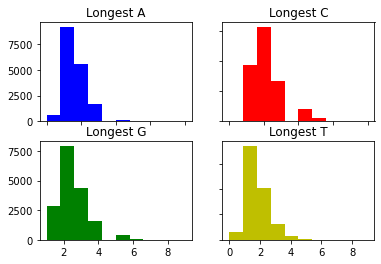

In [29]:
# look at longest consecutive run
fig, axs = plt.subplots(2, 2)

axs[0, 0].hist(activity_score_df['longest A'], color="b")
axs[0, 0].set_title('Longest A')
axs[0, 1].hist(activity_score_df['longest C'], color="r")
axs[0, 1].set_title('Longest C')
axs[1, 0].hist(activity_score_df['longest G'], color="g")
axs[1, 0].set_title('Longest G')
axs[1, 1].hist(activity_score_df['longest T'], color="y")
axs[1, 1].set_title('Longest T')

for ax in fig.get_axes():
    ax.label_outer()

---

# Feature: sgRNA Length

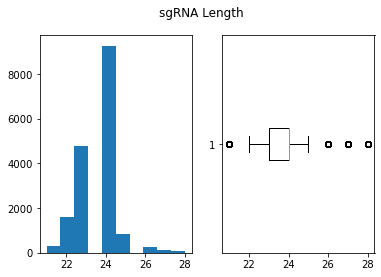

In [30]:
fig, axs = plt.subplots(1, 2)
fig.suptitle("sgRNA Length")


axs[0].hist(activity_score_df['length'])
axs[1].boxplot(activity_score_df['length'], vert=False)

plt.show()

---

# Feature: Nucleotides at Each Position

To maintain the nucleotide at each position, we will create a new dataframe with one row for every sgRNA sequence in `activity_scores_df` and one column for each position in the longest sequence. Necessarily, some cells will have empty spaces since not all sequences are of equal length.

In [34]:
# get each sequence as a string of the same length, right justified
max_len = max(activity_score_df['sequence'].str.len())
sequence_rjust = activity_score_df['sequence'].apply(lambda x : x.rjust(max_len))

In [35]:
sgRNA_bases = pd.DataFrame(sequence_rjust.apply(list).tolist())
sgRNA_bases['length'] = activity_score_df['sequence'].str.len()
sgRNA_bases

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,length
0,,,,,G,C,G,C,T,C,...,G,A,C,G,G,A,G,C,G,21
1,,,,,G,C,C,C,C,A,...,G,G,C,C,C,C,G,C,G,21
2,,,,,G,G,C,C,G,C,...,A,G,A,G,C,T,C,T,G,21
3,,,,,G,A,C,G,G,C,...,A,G,G,A,G,A,G,G,T,21
4,,,,,G,G,T,G,C,A,...,C,C,T,T,G,G,C,G,G,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17245,,,,,G,T,A,A,T,C,...,A,T,T,G,T,G,G,G,A,21
17246,,,,,,G,T,G,A,C,...,G,T,A,A,T,C,T,T,A,20
17247,,,,,G,T,G,G,A,T,...,A,G,C,G,G,C,G,A,A,21
17248,,,,,G,A,C,A,C,C,...,A,C,C,T,A,A,G,A,C,21


In [42]:
def get_one_hot_from_cell(cell):
    """
    Returns a list which is the one-hot encoding of 
    for nucleotides.
    
    Args:
        seq (str): The sgRNA sequence.

    Returns:
        4-tuple: the entries are the longest consecutive
        run of 'A', 'C', 'G', and 'T' in that order.
    """
    d = {
        ' ' : (0, 0, 0, 0),
        'A' : (1, 0, 0, 0), 
        'C' : (0, 1, 0, 0),
        'G' : (0, 0, 1, 0),
        'T' : (0, 0, 0, 1)
    }
    return d[cell]

In [58]:
prefix = dict()

for i in range(max_len):
    prefix[i] = "pos" + str(i)

In [74]:
a = pd.DataFrame([25 * ['A'] + [0]], columns=sgRNA_bases.columns.tolist())
c = pd.DataFrame([25 * ['C'] + [0]], columns=sgRNA_bases.columns.tolist())
g = pd.DataFrame([25 * ['G'] + [0]], columns=sgRNA_bases.columns.tolist())
t = pd.DataFrame([25 * ['T'] + [0]], columns=sgRNA_bases.columns.tolist())
tmp = sgRNA_bases.append(a).append(c).append(g).append(t).replace(' ', np.nan)

In [75]:
pd.get_dummies(tmp, prefix=prefix, dummy_na = False)

,length,pos0_A,pos0_C,pos0_G,pos0_T,pos1_A,pos1_C,pos1_G,pos1_T,pos2_A,...,pos22_G,pos22_T,pos23_A,pos23_C,pos23_G,pos23_T,pos24_A,pos24_C,pos24_G,pos24_T
0,21,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
1,21,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
2,21,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,21,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
4,21,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17249,20,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
0,0,1,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
0,0,0,0,1,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,1,0


In [226]:
# base_encodings = {
#     'A' : 0, 
#     'C' : 1, 
#     'G' : 2, 
#     'T' : 3, 
# }

# for base, repl in _base_encodings.items():
#     sgRNA_bases.replace(dimer, repl, inplace = True)
    
# sgRNA_bases.head()

---

# Feature: Nucleotide Composition

In [216]:
As = []
Cs = []
Gs = []
Ts = []

for index, row in sgRNA_bases.iterrows():
    length = row['length']
    As.append(sum(row == 'A') / length)
    Cs.append(sum(row == 'C') / length)
    Gs.append(sum(row == 'G') / length)
    Ts.append(sum(row == 'T') / length)
    
sgRNA_bases['As'] = As
sgRNA_bases['Cs'] = Cs
sgRNA_bases['Gs'] = Gs
sgRNA_bases['Ts'] = Ts

sgRNA_bases.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,length,As,Cs,Gs,Ts
0,G,C,G,C,T,C,T,G,A,T,...,G,None,None,None,None,21,0.142857,0.238095,0.428571,0.190476
1,G,C,C,C,C,A,G,G,A,T,...,G,None,None,None,None,21,0.142857,0.476190,0.333333,0.047619
2,G,G,C,C,G,C,C,C,T,C,...,G,None,None,None,None,21,0.095238,0.380952,0.380952,0.142857
3,G,A,C,G,G,C,G,A,C,C,...,T,None,None,None,None,21,0.238095,0.238095,0.428571,0.095238
4,G,G,T,G,C,A,G,C,G,G,...,G,None,None,None,None,21,0.047619,0.285714,0.523810,0.142857


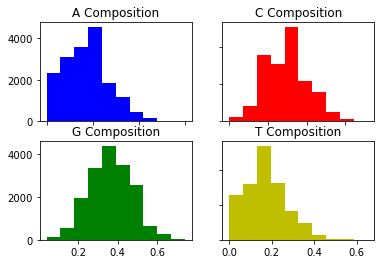

In [217]:
# look at nucleotide composition
fig, axs = plt.subplots(2, 2)

axs[0, 0].hist(sgRNA_bases['As'], color="b")
axs[0, 0].set_title('A Composition')
axs[0, 1].hist(sgRNA_bases['Cs'], color="r")
axs[0, 1].set_title('C Composition')
axs[1, 0].hist(sgRNA_bases['Gs'], color="g")
axs[1, 0].set_title('G Composition')
axs[1, 1].hist(sgRNA_bases['Ts'], color="y")
axs[1, 1].set_title('T Composition')

for ax in fig.get_axes():
    ax.label_outer()

---

# Feature: Dimers at Each Position

Similarly, to maintain the dimer at each position, we will create a new dataframe with one row for every sgRNA sequence in `activity_scores_df` and one column for each dimer position in the longest sequence. Necessarily, some columns will have `None` since not all sequences are of equal length.

In [218]:
def get_seq_dimers(seq):
    """
    This function returns the dimers of an input sequence
    as a list of two-character strings.
    
    Args:
        seq (str): The sgRNA sequence.

    Returns:
        list: the entry at position i is the ith dimer,
        captured as a two-character string.
    """
    return [seq[i:i+2] for i in range(0, len(seq)-1)]

In [224]:
sgRNA_dimers = pd.DataFrame(activity_score_df['sequence'].apply(get_seq_dimers).tolist())

# subtract one b/c one fewer dimers than bases
sgRNA_dimers['length'] = activity_score_df['sequence'].str.len() - 1

sgRNA_dimers

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,length
0,GC,CG,GC,CT,TC,CT,TG,GA,AT,TT,...,GG,GA,AG,GC,CG,None,None,None,None,20
1,GC,CC,CC,CC,CA,AG,GG,GA,AT,TC,...,CC,CC,CG,GC,CG,None,None,None,None,20
2,GG,GC,CC,CG,GC,CC,CC,CT,TC,CG,...,GC,CT,TC,CT,TG,None,None,None,None,20
3,GA,AC,CG,GG,GC,CG,GA,AC,CC,CC,...,AG,GA,AG,GG,GT,None,None,None,None,20
4,GG,GT,TG,GC,CA,AG,GC,CG,GG,GG,...,TG,GG,GC,CG,GG,None,None,None,None,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17245,GT,TA,AA,AT,TC,CT,TT,TA,AG,GG,...,GT,TG,GG,GG,GA,None,None,None,None,20
17246,GT,TG,GA,AC,CT,TT,TC,CA,AA,AA,...,TC,CT,TT,TA,None,None,None,None,None,19
17247,GT,TG,GG,GA,AT,TG,GT,TG,GG,GG,...,GG,GC,CG,GA,AA,None,None,None,None,20
17248,GA,AC,CA,AC,CC,CT,TC,CA,AG,GG,...,TA,AA,AG,GA,AC,None,None,None,None,20


In [227]:
# dimer_encodings = {
#     'AA' : 0, 
#     'AC' : 1, 
#     'AG' : 2, 
#     'AT' : 3, 
#     'CA' : 4, 
#     'CC' : 5, 
#     'CG' : 6, 
#     'CT' : 7,          
#     'GA' : 8, 
#     'GC' : 9, 
#     'GG' : 10, 
#     'GT' : 11, 
#     'TA' : 12, 
#     'TC' : 13, 
#     'TG' : 14, 
#     'TT' : 15
# }

# for dimer, repl in encodings.items():
#     sgRNA_dimers.replace(dimer, repl, inplace = True)
    
# sgRNA_dimers.head()

---

# Feature: Dimer Composition

In [230]:
# Relevant dimers that the paper decsribes: GC, CA, AG
GC = []
CA = []
AG = []

for index, row in sgRNA_dimers.iterrows():
    length = row['length']
    GC.append(sum(row == 'GC') / length)
    CA.append(sum(row == 'CA') / length)
    AG.append(sum(row == 'AG') / length)

sgRNA_dimers['GC'] = GC
sgRNA_dimers['CA'] = CA
sgRNA_dimers['AG'] = AG
              
sgRNA_dimers

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,length,GC,CA,AG
0,GC,CG,GC,CT,TC,CT,TG,GA,AT,TT,...,GC,CG,None,None,None,None,20,0.150000,0.000000,0.050000
1,GC,CC,CC,CC,CA,AG,GG,GA,AT,TC,...,GC,CG,None,None,None,None,20,0.150000,0.100000,0.100000
2,GG,GC,CC,CG,GC,CC,CC,CT,TC,CG,...,CT,TG,None,None,None,None,20,0.150000,0.000000,0.100000
3,GA,AC,CG,GG,GC,CG,GA,AC,CC,CC,...,GG,GT,None,None,None,None,20,0.050000,0.000000,0.150000
4,GG,GT,TG,GC,CA,AG,GC,CG,GG,GG,...,CG,GG,None,None,None,None,20,0.200000,0.050000,0.050000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17245,GT,TA,AA,AT,TC,CT,TT,TA,AG,GG,...,GG,GA,None,None,None,None,20,0.000000,0.000000,0.050000
17246,GT,TG,GA,AC,CT,TT,TC,CA,AA,AA,...,TA,None,None,None,None,None,19,0.000000,0.052632,0.052632
17247,GT,TG,GG,GA,AT,TG,GT,TG,GG,GG,...,GA,AA,None,None,None,None,20,0.100000,0.000000,0.050000
17248,GA,AC,CA,AC,CC,CT,TC,CA,AG,GG,...,GA,AC,None,None,None,None,20,0.000000,0.100000,0.100000


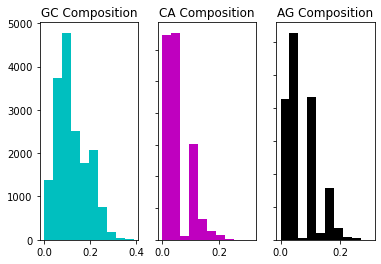

In [235]:
# look at nucleotide composition
fig, axs = plt.subplots(1, 3)

axs[0].hist(sgRNA_dimers['GC'], color="c")
axs[0].set_title('GC Composition')
axs[1].hist(sgRNA_dimers['CA'], color="m")
axs[1].set_title('CA Composition')
axs[2].hist(sgRNA_dimers['AG'], color="k")
axs[2].set_title('AG Composition')

for ax in fig.get_axes():
    ax.label_outer()

---

# Feature: Distances to TSS Sites

In [237]:
primary_five = []
primary_three = []
secondary_five = []
secondary_three = []

annot_genes = tss_annotation_df['gene']

for index, row in activity_score_df.iterrows():
    
    gene = row['gene']
    PAM_coord = row['coordinate']
    
    primary_five.append(tss_annotation_df["prim 5'"][annot_genes == gene].values[0] - PAM_coord)
    primary_three.append(tss_annotation_df["prim 3'"][annot_genes == gene].values[0] - PAM_coord)
    secondary_five.append(tss_annotation_df["snd 5'"][annot_genes == gene].values[0] - PAM_coord)
    secondary_three.append(tss_annotation_df["snd 3'"][annot_genes == gene].values[0] - PAM_coord)
    
activity_score_df["dist prim 5'"] = primary_five
activity_score_df["dist prim 3'"] = primary_three
activity_score_df["dist snd 5'"] = secondary_five
activity_score_df["dist snd 3'"] = secondary_three

In [238]:
activity_score_df.head()

,level_0,index,gene,chromosome,coordinate,strand,length,sequence,score,+ve strand,longest A,longest C,longest G,longest T,dist prim 5',dist prim 3',dist snd 5',dist snd 3'
0,0,0,AARS,chr16,70323441,+,24,GCGCTCTGATTGGACGGAGCG,0.019320,1,1,1,2,2,-58,-20,-19,22
1,1,1,AARS,chr16,70323216,+,24,GCCCCAGGATCAGGCCCCGCG,0.348892,1,1,4,2,1,167,205,206,247
2,2,2,AARS,chr16,70323296,+,24,GGCCGCCCTCGGAGAGCTCTG,0.912409,1,1,3,2,1,87,125,126,167
3,3,3,AARS,chr16,70323318,+,24,GACGGCGACCCTAGGAGAGGT,0.997242,1,1,3,2,1,65,103,104,145
4,4,4,AARS,chr16,70323362,+,24,GGTGCAGCGGGCCCTTGGCGG,0.962154,1,1,3,3,2,21,59,60,101


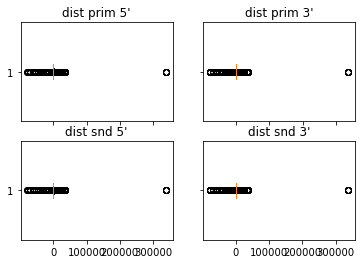

In [242]:
# look at distances
fig, axs = plt.subplots(2, 2)

axs[0, 0].boxplot(activity_score_df["dist prim 5'"], vert=False)
axs[0, 0].set_title("dist prim 5'")
axs[0, 1].boxplot(activity_score_df["dist prim 3'"], vert=False)
axs[0, 1].set_title("dist prim 3'")
axs[1, 0].boxplot(activity_score_df["dist snd 5'"], vert=False)
axs[1, 0].set_title("dist snd 5'")
axs[1, 1].boxplot(activity_score_df["dist snd 3'"], vert=False)
axs[1, 1].set_title("dist snd 3'")

for ax in fig.get_axes():
    ax.label_outer()

**TODO**: These boxplots suggest that there are several outliers among the distances. This may be because of incorrect annotations. Further investigation is necessary.

---

# Relationship between CRISPRi activity and sgRNA position relative to the TSS as predicted by SVR.

In [97]:
model = svm.SVR().fit(X, y)
model.score(x_test, y_test)

-0.05343531362356391

In [101]:
# SVR trained on an 80% division of the CRISPRi activity score dataset
# using the position of the sgRNA relative to the upstream end of TSS for each gene.
train_size = int(0.8 * activity_score_df.shape[0])
X = np.array(activity_score_df['Dist to Primary TSS 3'][0:train_size]).reshape(-1, 1)
y = np.array(activity_score_df['CRISPRi activity score [Horlbeck et al., eLife 2016]'][0:train_size])

x_test = np.array(activity_score_df['Dist to Primary TSS 3'][train_size:]).reshape(-1, 1)
y_test = np.array(activity_score_df['CRISPRi activity score [Horlbeck et al., eLife 2016]'][train_size:])

print(X.shape)
print(y.shape)
print(X)
print(y)

(14690, 1)
(14690,)
[[  20]
 [-205]
 [-125]
 ...
 [ -22]
 [ -94]
 [-103]]
[ 0.01932036  0.34889211  0.91240883 ...  0.47415147 -0.04741211
  0.7370698 ]


In [99]:
regr = make_pipeline(StandardScaler(), SVR(kernel='rbf'))
fit = regr.fit(X, y) 

# y_pred = regr.predict(x_test)
fit.score(x_test, y_test)
             

# Hyperparameter values for SVR were selected automatically using cross-validation 
# within the training set. 



-0.05295051456507504

In [112]:
from sklearn.metrics import roc_auc_score

In [118]:
def regression_svm(
    x_train, y_train, x_test, y_test, logC, logGamma):
    '''
        Estimate a SVM regressor
    '''
    # create the regressor object
    sv = svm.SVR(kernel='rbf', 
        C=0.1 * logC, gamma=0.1 * logGamma)

    # estimate the model
    sv.fit(x_train,y_train)

    # decision function
    decision_values = sv.score(x_test, y_test)

    # return the object
    return decision_values

# find the optimal values of C and gamma 

In [45]:
# param_grid = [
#   {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
#  ]
# svr = svm.SVR()
# clf = GridSearchCV(svr, param_grid)
# model = clf.fit(X, y)
# model.score(X)

In [162]:
model.get_params()

{'cv': None,
 'error_score': nan,
 'estimator__C': 1.0,
 'estimator__cache_size': 200,
 'estimator__coef0': 0.0,
 'estimator__degree': 3,
 'estimator__epsilon': 0.1,
 'estimator__gamma': 'scale',
 'estimator__kernel': 'rbf',
 'estimator__max_iter': -1,
 'estimator__shrinking': True,
 'estimator__tol': 0.001,
 'estimator__verbose': False,
 'estimator': SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
     kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
 'iid': 'deprecated',
 'n_jobs': None,
 'param_grid': [{'C': [1, 10, 100, 1000],
   'gamma': [0.001, 0.0001],
   'kernel': ['rbf']}],
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 0}

In [ ]:
# To display the relationship between sgRNA position and CRISPRi activity fit by this model, 
# predicted scores were generated for each position within a 3 kb window around the TSS. 
# Graph produced --> lets make it too!!!

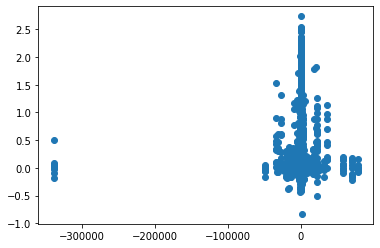

In [126]:
#x_pseudo = np.arange(-1500,1500)
#y_pred = regr.predict(x_pseudo.reshape(-1, 1))
#plt.scatter(x_pseudo, y_pred)
plt.scatter(X, y)

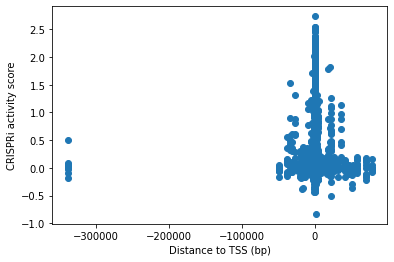

In [92]:
plt.xlabel('Distance to TSS (bp)')
plt.ylabel('CRISPRi activity score')
plt.scatter(np.array(activity_score_df['Dist to Primary TSS 5']), np.array(activity_score_df['CRISPRi activity score [Horlbeck et al., eLife 2016]']))

In [128]:
len(activity_score_df[activity_score_df['Dist to Primary TSS 5'] < -100000])

8

In [141]:
tmp = activity_score_df[(activity_score_df['Dist to Primary TSS 5'] > -1500) & (activity_score_df['Dist to Primary TSS 5'] < 1500)]
tmp.head()

,gene symbol,chromosome,PAM genomic coordinate [hg19],strand targeted,sgRNA length (including PAM),sgRNA sequence,"CRISPRi activity score [Horlbeck et al., eLife 2016]",Dist to Primary TSS 5,Dist to Primary TSS 3,Dist to Secondary TSS 5,Dist to Ssecondary TSS 5
0,AARS,chr16,70323441,+,24,GCGCTCTGATTGGACGGAGCG,0.019320,58,20,19,-22
1,AARS,chr16,70323216,+,24,GCCCCAGGATCAGGCCCCGCG,0.348892,-167,-205,-206,-247
2,AARS,chr16,70323296,+,24,GGCCGCCCTCGGAGAGCTCTG,0.912409,-87,-125,-126,-167
3,AARS,chr16,70323318,+,24,GACGGCGACCCTAGGAGAGGT,0.997242,-65,-103,-104,-145
4,AARS,chr16,70323362,+,24,GGTGCAGCGGGCCCTTGGCGG,0.962154,-21,-59,-60,-101


In [166]:
train_size = int(0.8 * tmp.shape[0])
X = np.array(tmp['Dist to Primary TSS 5'][0:train_size]).reshape(-1, 1)
y = np.array(tmp['CRISPRi activity score [Horlbeck et al., eLife 2016]'][0:train_size])

x_test = np.array(tmp['Dist to Primary TSS 5'][train_size:]).reshape(-1, 1)
y_test = np.array(tmp['CRISPRi activity score [Horlbeck et al., eLife 2016]'][train_size:])

regr = make_pipeline(StandardScaler(), SVR(kernel='rbf'))
fit = regr.fit(X, y) 

# y_pred = regr.predict(x_test)
fit.score(X, y)


0.015157855602923929

In [157]:
preds = fit.predict(X.reshape(-1, 1))
resid = sum((preds - y)**2)
ybar = np.mean(y)
tot = sum((y - ybar)**2)
1 - resid / tot

0.016309751550210527

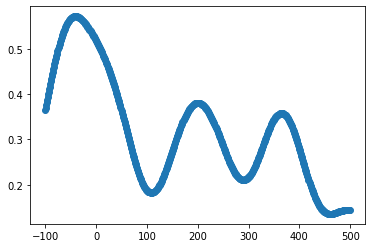

In [165]:
x_pseudo = np.arange(-100,500)
y_pred = model.predict(x_pseudo.reshape(-1, 1))
plt.scatter(x_pseudo, y_pred)

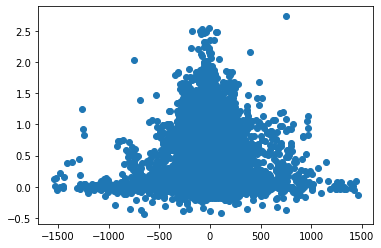

In [144]:
plt.scatter(X, y)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9fb70eb6a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9fb70ebda0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9fb70eb550>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9fb71174e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9fb7117860>],
 'means': []}

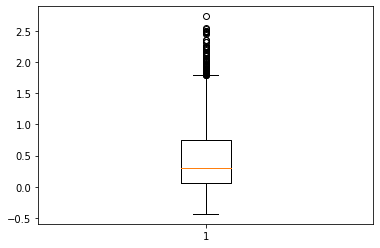

In [147]:
plt.boxplot(y)